In [1]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import matplotlib
import matplotlib.colors as colors
import metpy.calc as mpc
import xarray as xr
from utils import *
from math import log10, floor
import cftime

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# simulation parameters
rot = True
small_earth_fact = 60 
center_lon = 120

In [3]:
# Information about the paths
model = 'SE' # or 'FV3' or 'MPAS'
vert = 'nonhydrostatic' # or 'nonhydrostatic'

# Name of your CAM clone:
CAM_dirname = 'CAM_6_4_060_06032025'

# Edit this to your own case name
case = 'dcmip2025_squall_se_ne30'

# Modify the following according to your naming convention
if rot:
    nc_file = case + '.cam.h0i.0001-01-01-00000.nc'
else:
    nc_file = case + '.cam.h0i.0001-01-01-00000.nc'

# Define the base root to the data,
# add your username
username = 'nandrosk'
run_base = f'/glade/derecho/scratch/{username}/'
output_base = f'/glade/u/home/{username}/'

# Automatically set some paths
run_path = run_base + case + '/run/' + nc_file
# output_dir = f'{CAM_dirname}/plotting/'
# output_file = output_base + output_dir

In [4]:
ds = xr.open_dataset(run_path)

In [5]:
# Extract the data
nc = Dataset(run_path)
time_stamps = nc['time'][:]
lats = nc['lat'][:] 
lons = nc['lon'][:] 
levs = nc['lev'][:]

print(f'There are {len(time_stamps)} time samples')
print(f'{len(lats)} latitiude points, {len(lons)} longitude points')

There are 37 time samples
181 latitiude points, 360 longitude points


In [6]:
# Specify the altitude, field and times you want to plot
z_val = 300 # in metres for 3d fields
two_d = True # 2d fields - PRECT, TMQ, TMRAINQM, TMCLDLIQ
field = 'PRECT' # 3d fields - T or U or V or W or div or vor or Q
t_idxs = [9, 18, 27, 36] # Each index is 0.25 small Earth hours
# t_idxs = [1, 18, 36]

In [7]:
# Crop to the subdomain of interest

lon_crop_left = 70.
lon_crop_right = 250.
lon_ticks = np.linspace(80, 220, 8) # Plotting ticks

lat_crop_up = 40.
lat_crop_down = -40.
lat_ticks = np.linspace(-40,40,8) # Plotting ticks


lon_inds = np.where((lons > lon_crop_left) & (lons < lon_crop_right))[0]
lat_inds = np.where((lats > lat_crop_down) & (lats < lat_crop_up))[0]

print(f'Crop is of size, {len(lat_inds)} lat vals and {len(lon_inds)} lon vals')

lat_slice = lats[lat_inds] 
lon_slice = lons[lon_inds] 
LON_subset, LAT_subset = np.meshgrid(lon_slice, lat_slice)

Crop is of size, 79 lat vals and 180 lon vals


In [8]:
# Interpolate the 3d data at each time index:
if (not two_d):
    if (field == "vor" or field == "div"):
        uv = np.zeros((len(t_idxs), 2, len(lat_slice), len(lon_slice)))
        for i in range(len(t_idxs)):
            uv[i] = z_interp_uv(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc['U'][t_idxs[i], :, lat_inds, lon_inds], nc['V'][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
            print('interpolated time ' + str(i+1))
    elif (field == "W"):
        interp_field_vals = np.zeros((len(t_idxs), len(lat_slice), len(lon_slice)))
        if (model == 'MPAS'):
            for i in range(len(t_idxs)): # still needs to be tested
                interp_field_vals[i] = z_interp(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc['w'][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
                print('interpolated time ' + str(i+1))
        else:
            if (vert == 'hydrostatic'):
                for i in range(len(t_idxs)):
                    interp_field_vals[i] = z_interp_w_hydrostatic(nc, t_idxs[i], lon_inds, lat_inds, z_val)
                    print('interpolated time ' + str(i+1))
            else: 
                for i in range(len(t_idxs)):
                    interp_field_vals[i] = z_interp_w_nonhydro(nc, t_idxs[i], lon_inds, lat_inds, z_val)
                    print('interpolated time ' + str(i+1))
    else:
        interp_field_vals = np.zeros((len(t_idxs), len(lat_slice), len(lon_slice)))
        for i in range(len(t_idxs)):
            interp_field_vals[i] = z_interp(nc['Z3'][t_idxs[i], :, lat_inds, lon_inds], nc[field][t_idxs[i], :, lat_inds, lon_inds], lon_slice, lat_slice, z_val)
            print('interpolated time ' + str(i+1))
else:
    # 2d, no interpolation needed
    interp_field_vals = nc[field][t_idxs, lat_inds, lon_inds]

In [9]:
if (field == "PRECT"):
    field_vals = 1000*60*60*24 * interp_field_vals
elif field == "vor":
    # compute vorticity
    uv_ds = xr.Dataset(data_vars = dict(
        U=(['time', 'lat', 'lon'], uv[:,0]), V=(['time', 'lat', 'lon'], uv[:,1])), 
        coords = dict(time=time_stamps[t_idxs], lat=lat_slice, lon=lon_slice))
    uv_ds['U'].attrs["units"] = "m/s"
    uv_ds['V'].attrs["units"] = "m/s"
    field_vals = small_earth_fact*mpc.vorticity(uv_ds['U'], uv_ds['V'])
elif field == "div":
    # compute divergence
    uv_ds = xr.Dataset(data_vars = dict(
        U=(['time', 'lat', 'lon'], uv[:,0]), V=(['time', 'lat', 'lon'], uv[:,1])), 
        coords = dict(time=time_stamps[t_idxs], lat=lat_slice, lon=lon_slice))
    uv_ds['U'].attrs["units"] = "m/s"
    uv_ds['V'].attrs["units"] = "m/s"
    field_vals = small_earth_fact*mpc.divergence(uv_ds['U'], uv_ds['V'])
else:
    field_vals = interp_field_vals

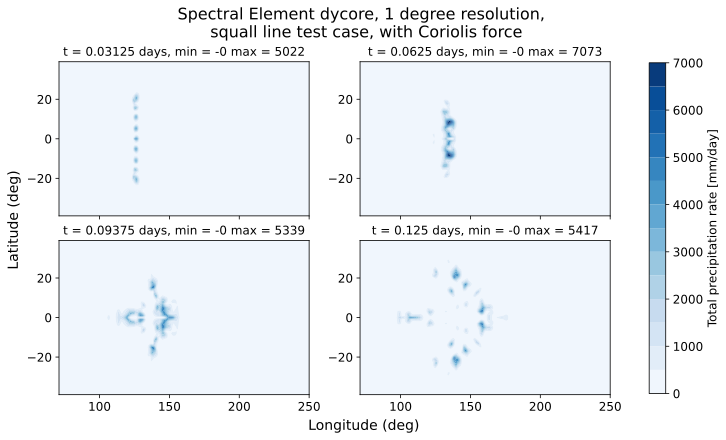

In [10]:
# Make the plot!
# fig, axes = plt.subplots(len(t_idxs),1, figsize=(6.5,10.0*len(t_idxs)/4.0), sharex=True, layout='constrained')
fig, axes = plt.subplots(2,2, figsize=(10.0,6.0), sharex=True, layout='constrained')

title_size=16
label_size=14
small_size=12
round_dig = 2

fix_minmax = False

# For the title
dycore_res = 'SE ne60'

# Feel free to add additional fields
if field == 'T':
    title = 'Temperature perturbation'
    cb_label = '$T - T_0$ [K]'
    min = -2
    max = 5
elif field == 'U':
    title = 'Normalised zonal velocity perturbation'
    cb_label = '$(u(t) - u_0)/u_0$ [m/s]'
    min = -1.5
    max = 0.6
elif field == 'V':
    title = "Meridional velocity"
    cb_label = '$v(t)$ [m/s]'
    min = -9
    max = 9
elif field == 'W':
    title = "Vertical velocity"
    cb_label = '$w(t)$ [m/s]'
    min = -0.2
    max = 0.36
elif field == "vor":
    title = "Relative vorticity"
    cb_label = '$\zeta(t)$ [1/s]'
    round_dig = 6
    min = -0.00014*small_earth_fact
    max = 0.00016*small_earth_fact
elif field == "div":
    title = "Fluid divergence"
    cb_label = '$\sigma(t)$ [1/s]'
    round_dig = 6
    min = -0.00003*small_earth_fact
    max = 0.00003*small_earth_fact
elif field == "Q":
    title = "Specific humidity"
    cb_label = 'mixing ratio'
    round_dig = 3
    min = 0
    max = 1
elif field == "PRECT":
    title = "Total precipitation rate"
    cb_label = '[mm/day]'
    round_dig = 0
    min = 0
    max = 0.01
elif field == "TMCLDLIQ":
    title = "Vertically integrated cloud liquid"
    cb_label = '$[kg/m^2]$'
    round_dig = 2
    min = 0
    max = 20
elif field == "TMRAINQM":
    title = "Column rain liquid"
    cb_label = '$[kg/m^2]$'
    min = 0
    max = 100

# for the color map
valmin = np.nanmin(field_vals)
valmax = np.nanmax(field_vals)
if ((-1e-10 > valmin) and (1e-10 < valmax)):
    if fix_minmax:
        norm = MidpointNormalize(midpoint = 0, vmin = min, vmax = max)
    else:
        norm = MidpointNormalize(midpoint = 0, vmin = valmin, vmax = valmax)
    cmap_choice = 'RdBu_r'
elif (valmin < 1e-10):
    cmap_choice = "Blues"
    if (fix_minmax):
        norm = colors.Normalize(vmin=min, vmax=max)
    else:
        norm = colors.Normalize(vmin=valmin, vmax=valmax)       
else:
    if (fix_minmax):
        norm = colors.Normalize(vmin=min, vmax=max)
    else:
        norm = colors.Normalize(vmin=valmin, vmax=valmax)
    cmap_choice = 'RdYlBu_r'

if fix_minmax:
    levels = 17
    levels = np.mgrid[min:max:levels*1j]
else:
    levels = 15
    valmin = round(valmin, -int(floor(log10(abs(valmin)))))
    valmax = round(valmax, -int(floor(log10(abs(valmax)))))
    levels = np.mgrid[valmin:valmax:levels*1j]

plts = []

for ind, ax in enumerate(np.ravel(axes)):
    if fix_minmax:
        plot = ax.contourf(LON_subset, LAT_subset, field_vals[ind], levels=levels, cmap=cmap_choice, norm=norm, extend='both')
    else:
        plot = ax.contourf(LON_subset, LAT_subset, field_vals[ind], levels=levels, cmap=cmap_choice, norm=norm)
    plts.append(plot)
    # ax.set_aspect('equal')
    ax.tick_params(axis='both', labelsize=small_size)
    ax.set_title(f't = {time_stamps[t_idxs[ind]]} days, min = ' + '%.*f' % (round_dig, np.nanmin(field_vals[ind])) + ' max = ' + '%.*f' % (round_dig, np.nanmax(field_vals[ind])))

cb = plt.colorbar(plts[0], ax=axes, fraction=0.03)
# cb = fig.colorbar(plts[0], ax=axes, fraction=0.03)
cb.set_label(label=title + " " + cb_label, size=small_size)
cb.ax.tick_params(labelsize=small_size)

fig.supylabel('Latitude (deg)', size=label_size)
fig.supxlabel('Longitude (deg)', size=label_size)

if rot:
    fig.suptitle('Spectral Element dycore, 1 degree resolution, \n squall line test case, with Coriolis force', size=title_size)
else:
    fig.suptitle('Spectral Element dycore, 1 degree resolution, \n squall line test case, without Coriolis force', size=title_size)

plt.show()

In [11]:
# measure how much asymmetry the model introduces
l2error = np.zeros(len(time_stamps))
south_inds = np.where(lats < 0)[0]
north_inds = np.where(lats > 0)[0][::-1]
for i in range(len(time_stamps)):
    if two_d:
        diff = nc[field][i,south_inds] - nc[field][i,north_inds]
    else:
        diff = nc[field][i,:,south_inds] - nc[field][i,:,north_inds] # add or subtract depending on the field
    # not available for vor, div, W
    l2error[i] = np.linalg.norm(diff)/np.size(diff)

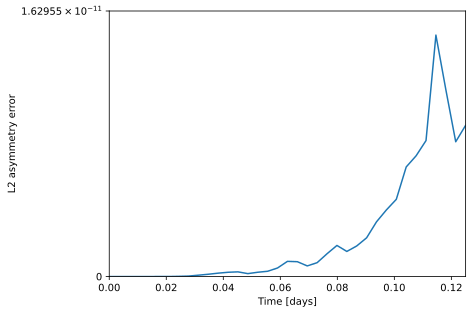

In [12]:
plt.plot(time_stamps, l2error)
plt.xlabel('Time [days]')
plt.ylabel('L2 asymmetry error')
plt.ylim(0, 1.1*np.max(l2error))
plt.xlim(0, time_stamps[-1])
plt.yscale('symlog', linthresh=1e-9)
plt.show()